# Campaign Impact Analysis

The bank is currently struggling with low engagement from its marketing campaigns, even though they possess extensive customer data. Given this situation, the bank requires a marketing strategy that focuses on awareness campaigns: introducing the brand and products to as many new audiences as possible. Through analysis, we will derive actionable insights on how the existing marketing strategies can be improved.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [18]:
campaigns_df = pd.read_csv("../../data/processed/campaigns.csv")
customer_df = pd.read_csv("../../data/processed/customer.csv")
digital_usage_df = pd.read_csv("../../data/processed/digital_usage.csv")
engagement_details_df = pd.read_csv("../../data/processed/engagement_details.csv")
loans_df = pd.read_csv("../../data/processed/loans.csv")
products_owned_df = pd.read_csv("../../data/processed/products_owned.csv")
transactions_df = pd.read_csv("../../data/processed/transactions.csv")
segmentation_df = pd.read_csv("../../customer_segmentation/customer_segments.csv")

print('Loaded Data Shapes:')
print('Campaign:', campaigns_df.shape)
print('Customer:', customer_df.shape)
print('DigitalUsage:', digital_usage_df.shape)
print('EngagementDetail:', engagement_details_df.shape)
print('Loan:', loans_df.shape)
print('ProductsOwned:', products_owned_df.shape)
print('Transaction:', transactions_df.shape)

Loaded Data Shapes:
Campaign: (99, 10)
Customer: (4000, 13)
DigitalUsage: (4000, 9)
EngagementDetail: (16000, 8)
Loan: (7920, 6)
ProductsOwned: (4000, 6)
Transaction: (6463, 5)


## Key Performance Indicators (KPI)

To effectively measure the success of our marketing campaigns and improve customer interactions, we have identified the following key performance indicators (KPIs):

1. Reach: This metric represents the number of unique customers who have been exposed to the campaign. It helps us understand the breadth of our campaign's audience and its potential impact.

2. Engagement Rate: This is the percentage of engagement attempts that result in a successful interaction with the customer. A higher engagement rate indicates that our campaign is resonating well with the audience and prompting them to take the desired action.

3. Conversion Rate: This measures the percentage of engaged customers who ultimately convert to taking the desired action (e.g., purchasing a product or service). Conversion rate helps us understand how effective our campaigns are at driving actual business outcomes.
 
4. Customer Lifetime Value (CLV): This represents the total worth of a customer to the business over the entirety of their relationship. Tracking CLV in relation to our campaigns helps us understand if we're effectively targeting and converting high-value customers.

By focusing on these KPIs, we aim to gain actionable insights into the effectiveness of our marketing strategies and make data-driven decisions to enhance customer engagement.

### Reach

Are we using the right communication channels to the right customer demographics?

Is it better to employ a marketing strategy with a focused approach to campaigns or with diverse campaigns types?


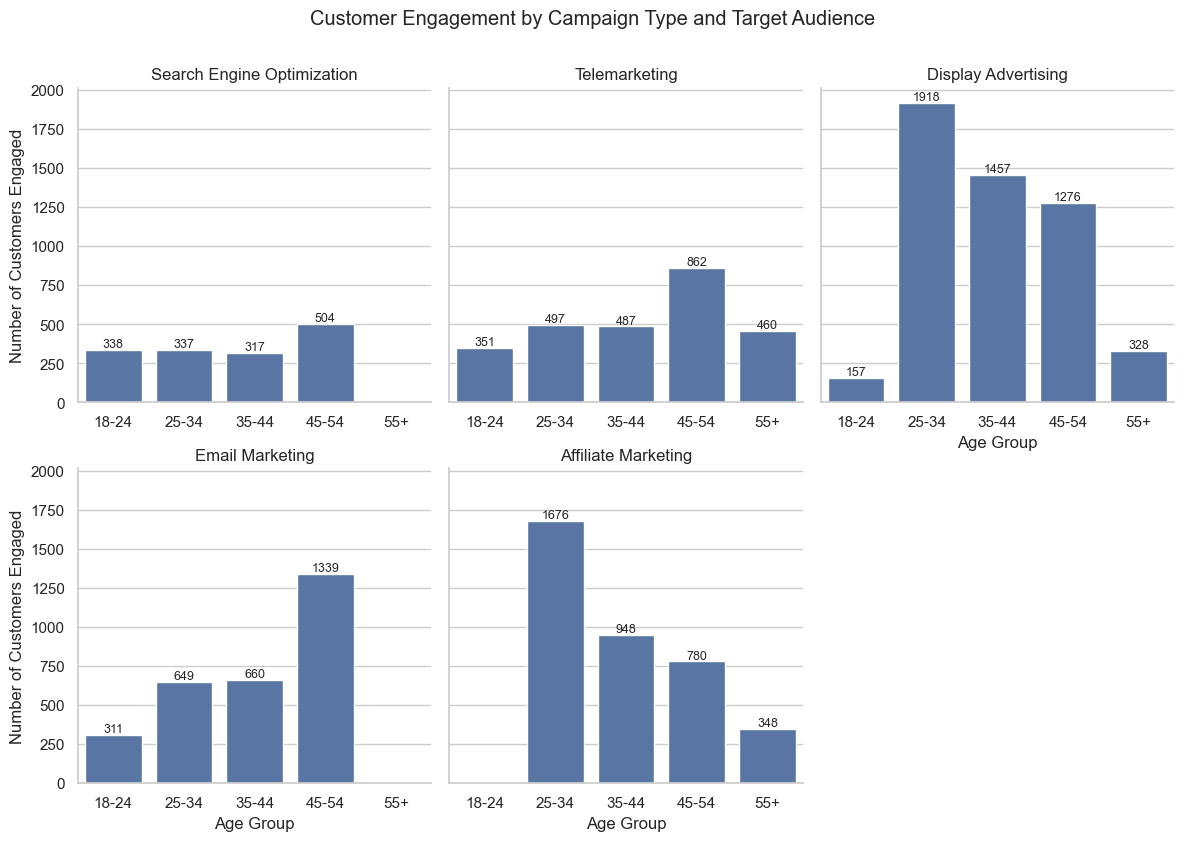

In [34]:
campaign_customers_df = engagement_details_df.merge(campaigns_df, on="campaign_id").merge(customer_df, on="customer_id").merge(segmentation_df, on="customer_id")
g = sns.FacetGrid(campaign_customers_df, col="campaign_type", col_wrap=3, height=4, sharex=False)
g.map_dataframe(sns.countplot, x='target_audience', order=sorted(campaign_customers_df['target_audience'].unique()))

# Annotate each bar with the count
for ax in g.axes.flat:
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 4),  # Offset text slightly above the bar
                    textcoords="offset points", 
                    ha='center', va='center', fontsize=9)

g.set_axis_labels('Age Group', 'Number of Customers Engaged')
g.set_titles(col_template='{col_name}')
g.figure.suptitle('Customer Engagement by Campaign Type and Target Audience', y=1.05)
plt.show()

In [20]:
campaign_customers_df[["target_audience", "age"]].head(10)

,target_audience,age
0,45-54,30
1,18-24,26
2,35-44,38
3,45-54,46
4,45-54,26
5,18-24,32
6,18-24,29
7,45-54,40
8,45-54,32
9,25-34,24


In [21]:
# Define a function to check if age is within the target audience range
def is_age_in_target(row):
    age = row['age']
    target = row['target_audience']
    if target == '18-24':
        return 18 <= age <= 24
    elif target == '25-34':
        return 25 <= age <= 34
    elif target == '35-44':
        return 35 <= age <= 44
    elif target == '45-54':
        return 45 <= age <= 54
    elif target == '55+':
        return age >= 55
    else:
        return False

# Apply the function to create a new column
campaign_customers_df['age_in_target'] = campaign_customers_df.apply(is_age_in_target, axis=1)

# Group by campaign_id and count the number of rows where age_in_target is False
age_mismatch_rate = campaign_customers_df.groupby('campaign_id').apply(lambda x: (~x['age_in_target']).mean(), include_groups=False) * 100

print("Percentage mismatch between campaign target audience and actual engaged customer age:")
print(age_mismatch_rate)

Percentage mismatch between campaign target audience and actual engaged customer age:
campaign_id
1     77.500000
2     81.767956
3     78.980892
4     68.211921
5     61.764706
        ...    
95    63.636364
96    92.857143
97    88.235294
98    85.135135
99    68.131868
Length: 99, dtype: float64


At first glance, it seemed like we had a reasonable distribution of target audience for our campaigns. For example, digital campaigns focused more on younger potential customers, while telemarketing emphasized more on older audiences. However, upon further inspection, it turns out our engagement efforts did not align with the campaign goals, and between 60% to 90% of our engagements were targeted at the wrong intended age group.

--> Action: coordinate engagement efforts to focus on the target audience

### Engagement rate:
- What portion of our engagements were successful?
- What are the characteristics of a campaign with high engagement rate?
- Which communication channels have a higher chance of customer interaction?
- Are we allocating our engagement efforts to the appropriate customer segments?

Overall Engagement Rate: 21.64%


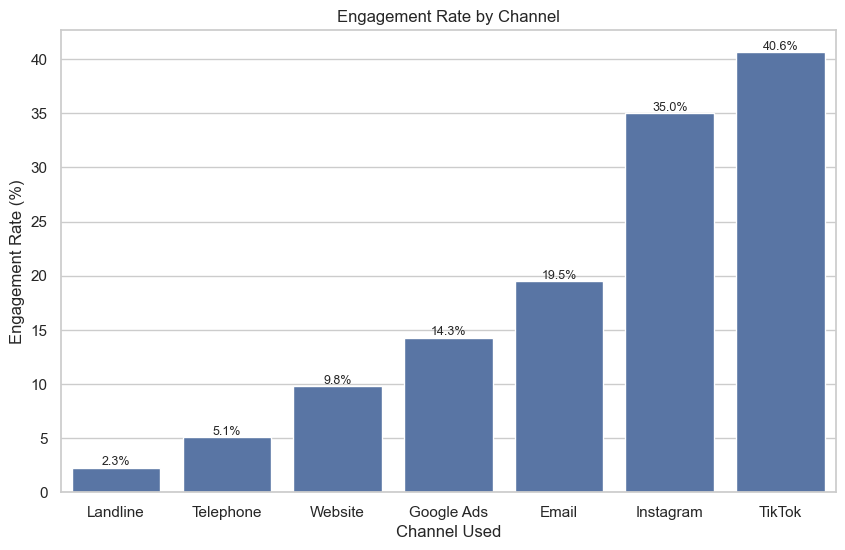

In [35]:
# Engagement rate overall
engagement_rate = engagement_details_df["has_engaged"].mean() * 100
print(f"Overall Engagement Rate: {engagement_rate:.2f}%")

# Engagement rate by communication channel used
engagement_campaign_df = engagement_details_df.merge(campaigns_df, on="campaign_id")
engagement_by_channel = engagement_campaign_df.groupby("channel_used")["has_engaged"].mean().sort_values() * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=engagement_by_channel.index, y=engagement_by_channel.values)
plt.title("Engagement Rate by Channel")
plt.xlabel("Channel Used")
plt.ylabel("Engagement Rate (%)")

# Annotate each bar with the number
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 4),  # Offset text slightly above the bar
                textcoords="offset points", 
                ha='center', va='center', fontsize=9)

plt.show()

It seems that while our average engagement rate is quite low at ~20%, this varies hugely by the channel used. Digital channels seem to perform better, especially social media platforms such as Tiktok and Instagram, which respond at ~40%, while tradional telemarketing has lower than 5% of success.

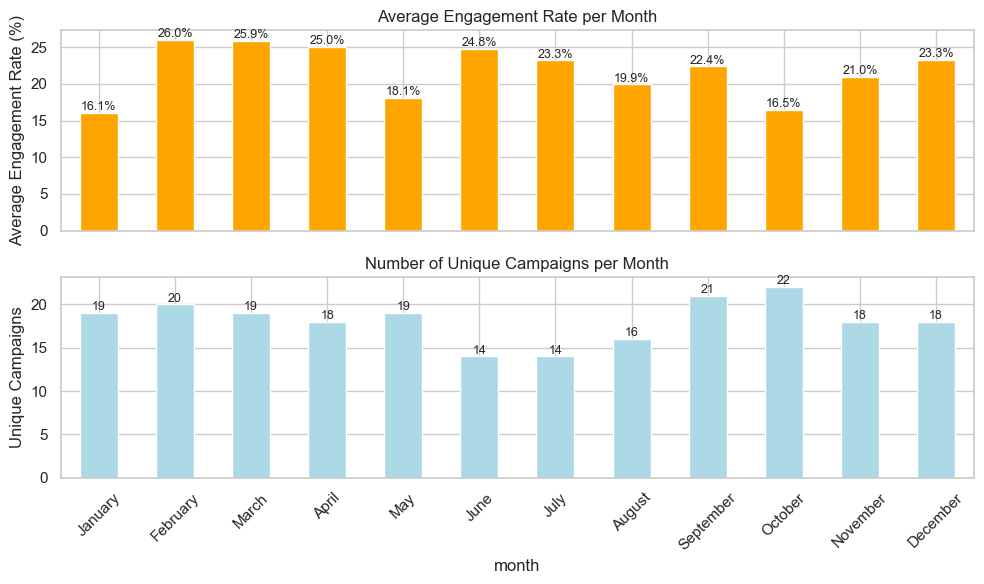

In [36]:
campaign_customers_df["month"] = pd.Categorical(campaign_customers_df["month"], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
engagement_rate = campaign_customers_df.groupby("month", observed=True)["has_engaged"].mean() * 100
campaign_counts = campaign_customers_df.groupby("month", observed=True)["campaign_id"].nunique().sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

engagement_rate.plot(kind='bar', ax=ax1, color='orange')
ax1.set_title('Average Engagement Rate per Month')
ax1.set_ylabel('Average Engagement Rate (%)')
ax1.set_xlabel('Month')

# Annotate bars in the first plot
for bar in ax1.patches:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%', 
                 xy=(bar.get_x() + bar.get_width() / 2, height), 
                 xytext=(0, 4),  # Offset text slightly above the bar
                 textcoords="offset points", 
                 ha='center', va='center', fontsize=9)

campaign_counts.plot(kind='bar', ax=ax2, color='lightblue')
ax2.set_title('Number of Unique Campaigns per Month')
ax2.set_ylabel('Unique Campaigns')

# Annotate bars in the second plot
for bar in ax2.patches:
    height = bar.get_height()
    ax2.annotate(f'{int(height)}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height), 
                 xytext=(0, 4),  # Offset text slightly above the bar
                 textcoords="offset points", 
                 ha='center', va='center', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interestingly, June has one of the highest engagement rates, yet we run the fewest campaigns during this month. Conversely, October has the most campaigns but the lowest engagement rate. This suggests that we could improve our campaign scheduling.

--> Action: Shift more campaigns to periods of high engagement to maximize the engagement rate.

### Conversion rate and CLV
- Do higher engagement corresponds to higher conversion rate?
- How good are we at converting higher CLV customer?

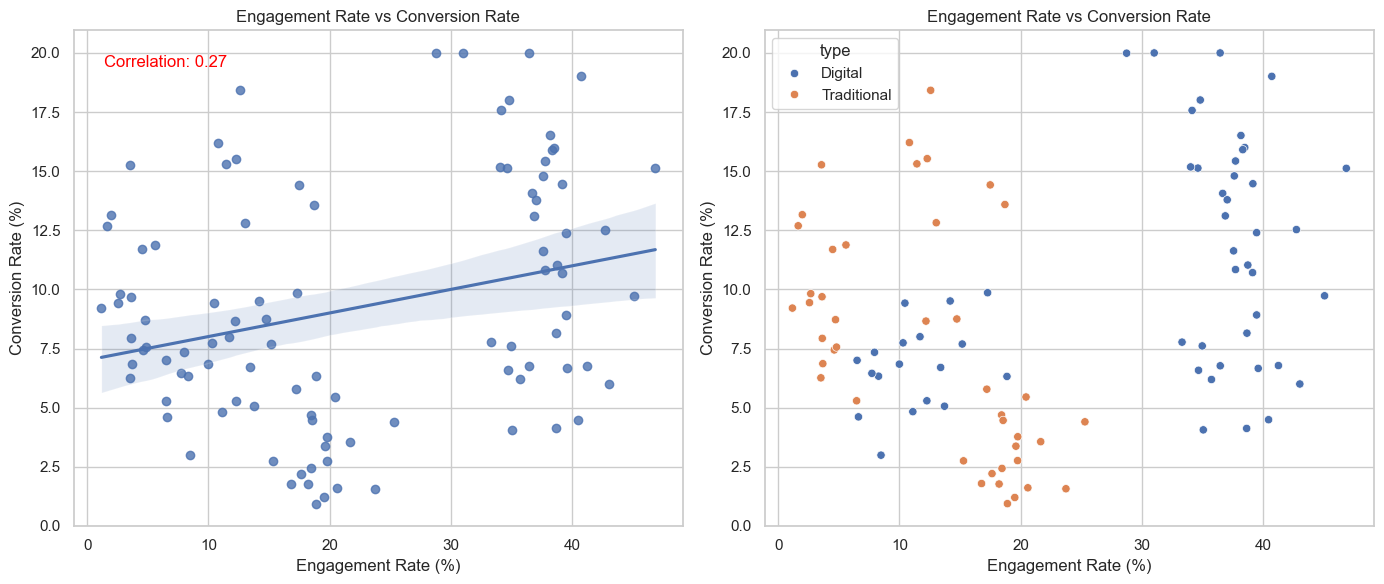

In [24]:
engagement_rate = engagement_details_df.groupby("campaign_id")["has_engaged"].mean() * 100
df = campaigns_df.merge(engagement_rate, on="campaign_id")
df["conversion_rate"] = df["conversion_rate"] * 100
df["type"] = df["campaign_type"].apply(lambda x: "Digital" if x in ["Display Advertising", "Affiliate Marketing"] else "Traditional")
correlation = df["conversion_rate"].corr(df["has_engaged"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.regplot(data=df, x="has_engaged", y="conversion_rate", ax=ax1)
ax1.set_title("Engagement Rate vs Conversion Rate")
ax1.set_xlabel("Engagement Rate (%)")
ax1.set_ylabel("Conversion Rate (%)")
ax1.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='red', ha='left', va='top')

sns.scatterplot(data=df, x="has_engaged", y="conversion_rate", hue="type", ax=ax2)
ax2.set_title("Engagement Rate vs Conversion Rate")
ax2.set_xlabel("Engagement Rate (%)")
ax2.set_ylabel("Conversion Rate (%)")

plt.tight_layout()
plt.show()

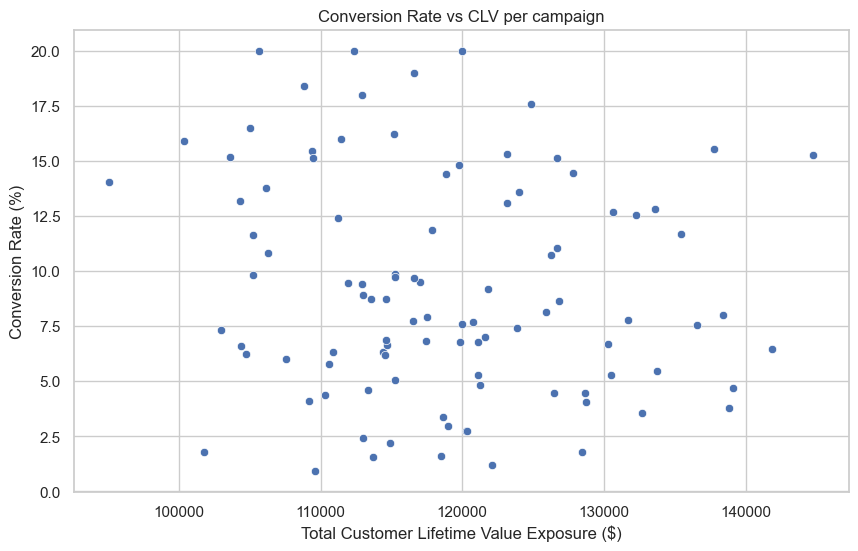

In [25]:
campaign_cltv_exposure = campaign_customers_df.groupby("campaign_id")["customer_lifetime_value"].sum()
df = campaigns_df.merge(campaign_cltv_exposure, on="campaign_id")
df["conversion_rate"] = df["conversion_rate"] * 100

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="customer_lifetime_value", y="conversion_rate")
plt.title("Conversion Rate vs CLV per campaign")
plt.xlabel("Total Customer Lifetime Value Exposure ($)")
plt.ylabel("Conversion Rate (%)")
plt.show()

Plotting engagement rate versus conversion rate per campaign, we observe a weak positive correlation. The scatter plot shows two clusters, explained by segmenting campaigns into digital and traditional efforts. This suggests that different campaign types have varying effectiveness.

When targeting higher value customers, we expect higher conversion rates. However, the plot of CLV versus conversion rate shows randomness, indicating that our current targeting strategy may not be effectively converting high-value customers.

<Figure size 2000x1000 with 0 Axes>

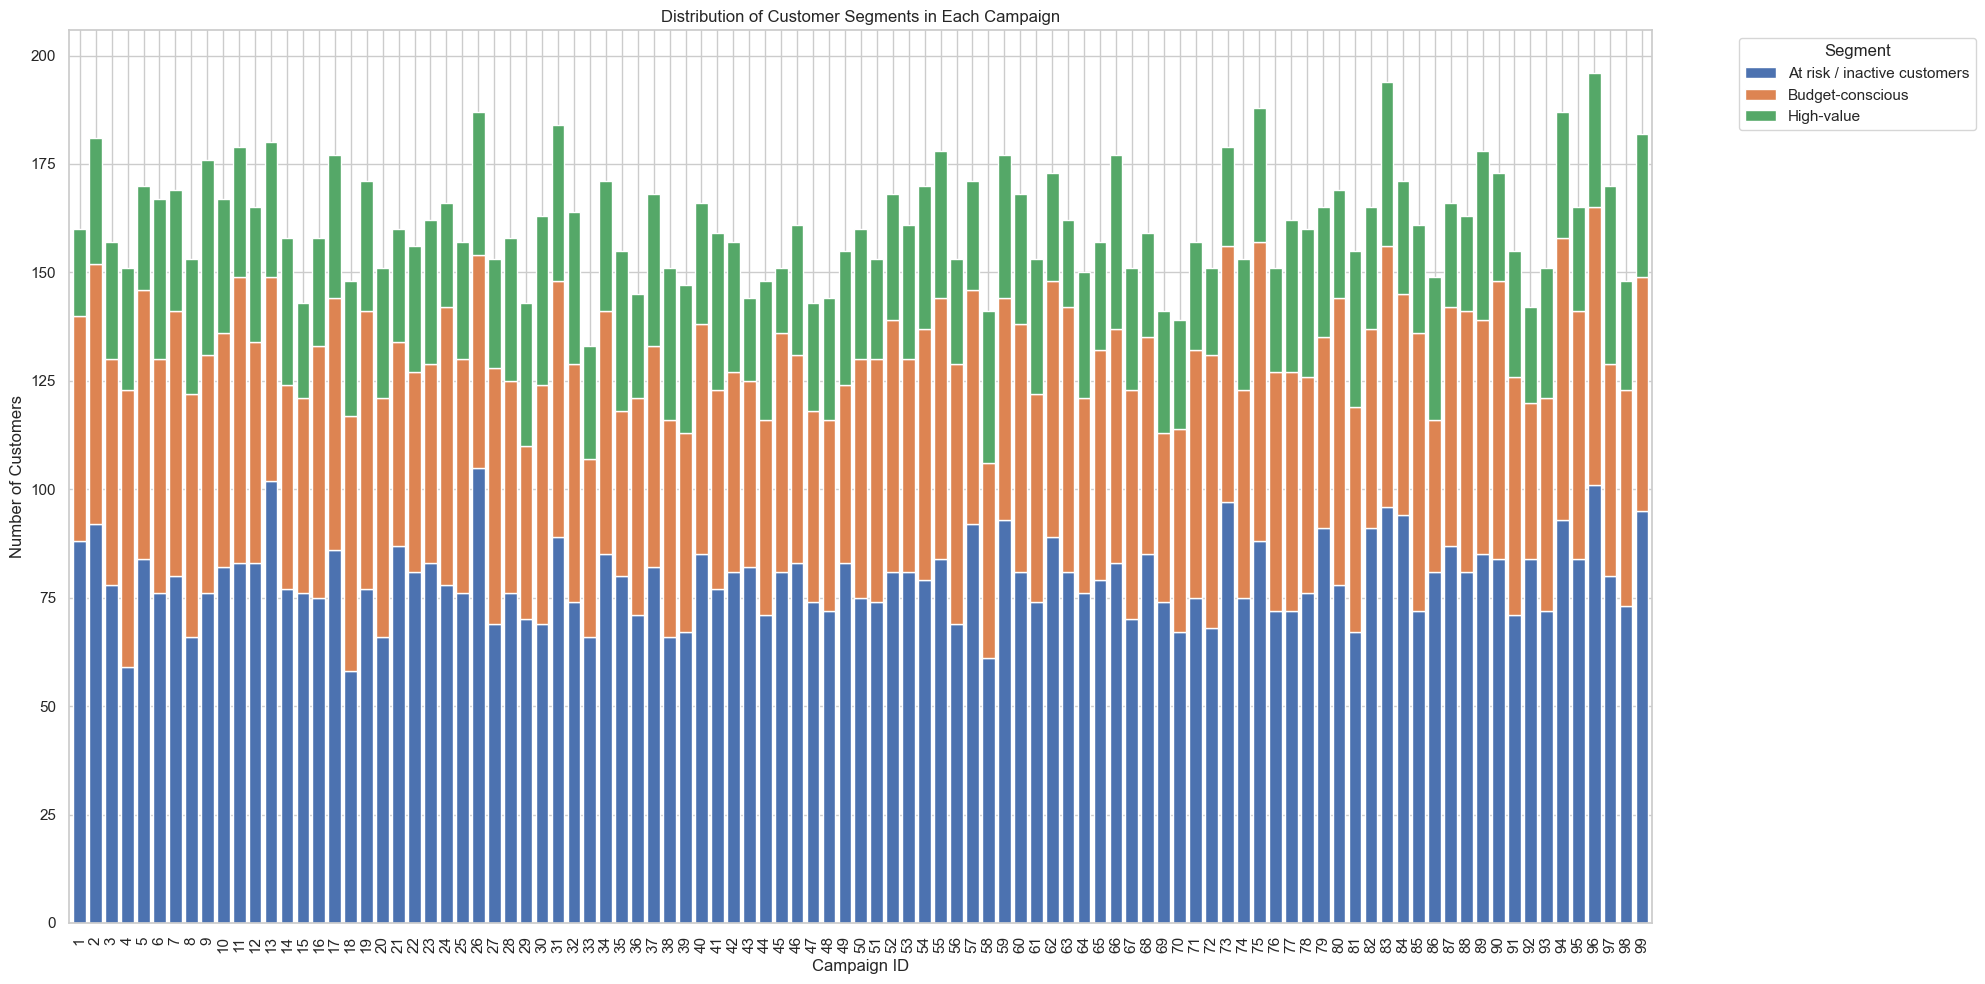

In [32]:
# Group by campaign_id and Segment to get the count of each segment in each campaign
segment_distribution = campaign_customers_df.groupby(["campaign_id", "Segment"]).size().unstack(fill_value=0)

# Plot the distribution of segments in each campaign
plt.figure(figsize=(20, 10))
segment_distribution.plot(kind='bar', stacked=True, figsize=(20, 10), width=0.8)  # Adjust the width parameter

plt.title('Distribution of Customer Segments in Each Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Number of Customers')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Looking at the high-level distribution of segments targeted in each campaign, we observe that while there are some variations, the distribution remains relatively even across different segments. This suggests that our current campaigns are not specialized enough to target specific customer segments effectively.

--> Action: We should organize specialized campaigns focusing on specific segments. For example, retention campaigns for inactive customers and loyalty campaigns for high-value customers can help improve engagement and conversion rates.

## Summary
- Key KPIs: Reach and engagement rate are critical metrics for evaluating the success of our marketing campaigns.
- Alignment: Ensure engagement efforts are consistent with campaign objectives.
- Seasonality: Consider the time of year when planning and organizing campaigns to optimize engagement.
- Specialization: Organize specialized campaigns each focusing on a specific segments